# Import libraries

In [442]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# EDA

In [93]:
raw_data = pd.read_csv('CupIT_Sber_data.csv', sep=';', decimal=',')
raw_data.head()

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
0,0xE3A4BED668151E271B6680FE5E8772D6,0xFDD38318ED6FC6EC68131DB6671F100C,2022-01-01 12:07:00.0000000,1925.0,0xD2B5A46F0FFF14D5209ED49B6215BDA0,0xCDEA5658E0AD52E1700653CAE2A4928D,0x95758EBA87326C4D5DECC8B51A8B9C61,0
1,0xD1DD45B19A9195143BE217BD83702901,0x9F7486A2D5FEFFF7453777B1D0592E16,2022-01-01 12:17:00.0000000,4800.0,0x0A1FF218569A9829DDA53CBDF9FD12F9,0x1ECB5F528158D6C0BC98B017169D3E5B,0x48137991AF094338080AC09C4A51E050,0
2,0xAB000FD6D4A66E6E1523907DEBFEC85D,0x72CBB210256CBF07F48DCACFDA4A3E4C,2022-01-01 12:30:00.0000000,1710.0,0xECA1B4580DFE64AC35678C0EC46CFB56,0x727B72BA7EB94341537D4FA18BAF9D7C,0x9F45909133FB97131C44DD00094F781E,0
3,0x53A548619940E6DF7D910D17905D1CFD,0x34082776539FC71066087BA9EB78986D,2022-01-01 12:33:00.0000000,2040.0,0xF3F9B8D552B3F35BD9F4E553E1C84AA8,0x5AF4EDF46C78DFB3049268F4C9708407,0xC311E151328A1118224B8A3F163AD3C0,0
4,0x1FDDAF54CB064A6E27519F2B6DF97B0E,0x5809EF65F6969882A139F7A484B8D95C,2022-01-01 12:27:00.0000000,2200.0,0xF599395DBD681B9A446C26F2DB9E0BF2,0xE6EEC1C29E25C790C0088B42F82CBA55,0x95758EBA87326C4D5DECC8B51A8B9C61,0


Посмотрим на тип данных каждого атрибута, если потребуется переопределим их в нужные форматы

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091043 entries, 0 to 1091042
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   service_document_id  1091043 non-null  object 
 1   account_document_id  1091043 non-null  object 
 2   service_date         1091043 non-null  object 
 3   service_amount_net   1091043 non-null  float64
 4   patient_id           1091043 non-null  object 
 5   service_code         1091043 non-null  object 
 6   service_name         1091043 non-null  object 
 7   is_hospital          1091043 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 66.6+ MB


Первое знакомство с данымми говорит нам о том, что пропущенных значений нет, у полей service_amount_net и is_hospital правильно считался формат данных.
Поле service_date необходимо преобразовать в datetime, остальные поля такие как service_code, service_name и подобные привести к категориям.
Поменяем тип данных service_date и соберем небольшую статистику.

In [94]:
raw_data['service_date'] = pd.to_datetime(raw_data['service_date'], yearfirst=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091043 entries, 0 to 1091042
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   service_document_id  1091043 non-null  object        
 1   account_document_id  1091043 non-null  object        
 2   service_date         1091043 non-null  datetime64[ns]
 3   service_amount_net   1091043 non-null  float64       
 4   patient_id           1091043 non-null  object        
 5   service_code         1091043 non-null  object        
 6   service_name         1091043 non-null  object        
 7   is_hospital          1091043 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 66.6+ MB


In [20]:
raw_data.describe()

,service_date,service_amount_net,is_hospital
count,1091043,1.091043e+06,1.091043e+06
mean,2023-01-10 23:05:27.043575296,2.335262e+03,9.259488e-02
min,2022-01-01 12:07:00,-2.525600e+05,0.000000e+00
25%,2022-07-14 11:04:00,4.200000e+02,0.000000e+00
50%,2023-01-16 20:02:00,1.304000e+03,0.000000e+00
75%,2023-07-11 08:59:00,2.480000e+03,0.000000e+00
max,2023-12-31 18:48:00,1.328586e+06,1.000000e+00
std,NaN,6.482097e+03,2.898640e-01


Обратим внимание, что минимальная выплата по страховке явлется отрицательной, по описанию задачи это "сторнировка", стоит посмотреть на такие записи. То есть сначала по одному документу (service_document_id) может быть выполнена выплата, а следом возврат (возможно неправильная сумма) или просто возврат, как корректировка, без последующей выплаты.

Максимальная же выплата составила 1.3 млн рублей, отчасти это может быть правдой, но стоит также проверить это.

In [96]:
raw_data.loc[raw_data['service_amount_net'] < 0].sort_values(by='service_amount_net')

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
647605,0xF86E5F558D370BABF2C9E15101A9348F,0x9A64C3C4241BEA1316CC93A40ED00468,2023-03-20 12:23:24,-252560.00,0x7D94A359561090239FE01A3DF066DDFB,0x0F501483E6323C629718F114E5491ECD,0x5741D77C8BAE5B3106A74F7F9E85EBC4,0
1024471,0x896BA0427B543B14D2F8AB920C0B3FA3,0x139D922DF67582AB05634BA7E255A8BD,2023-11-21 14:13:11,-155834.00,0x2F2203903C1ECA97E7D248EEE3DDE3B5,0xDE388F773B8279BCC11F05FADDBE15D1,0x754097ACC3CEF36BAD6D4260F0C0357B,1
900893,0x8958B43CC7517A3DEB0DA02432FB9FBF,0x85BE534C3277B12C4020CE48DF484195,2023-09-05 14:55:09,-101430.00,0xF43DF3E2D97251830380238008AE429D,0xCC3EFE31215AAC0952519ED07BB38BBB,0xD237C780A1FEF56E9D109A41A0229A6F,0
616484,0x5B658959715CE6D0108062E652E72698,0xA8122C976F7162440E3D7F384CBF70C7,2023-03-02 11:18:11,-87295.00,0xE30AD035CFA4BB0D9C0467CC4A56DF9B,0xF00F1F39075B51FDB018353EB48C467D,0xAB8574981BF01808E15343545DAD9237,1
597372,0xE1D90685449FE24F4818031C82B8D9FA,0x194A8D16D89C92DA8D99066AFD7D2119,2023-02-17 09:47:43,-81568.00,0xA87DF4FBB2E9D41AB5D970F22860E8AD,0x3B0C7D2A624320CBC4359EA05E13FC91,0x6B3FDE110D56ED97A50DAFCD7F05EB20,1
...,...,...,...,...,...,...,...,...
293194,0x6DCA515DF17047129999B43C5DB340C7,0x462BDC2FB02BBB84FB869A66BB39EDD3,2022-07-28 11:06:21,-2.28,0xDB56296D86A6B657BCBB84827B44E80C,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0
293555,0x8958C9201BE0C100ED1FC6EB0E048832,0xB3B11F0D3C83FF9D9C9F208B4F480A64,2022-07-28 11:06:23,-2.28,0xB0C4966A00BBDCD29B5C3A59B3891B79,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0
291964,0xB29DF459C3BCC8961133E24DD9B2BD22,0x155F4AC6E93B3F768F8B5A58B8005C70,2022-07-28 11:06:13,-2.28,0xC563B3CD53DB3A1C1861CF3BD381DA7D,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0
293098,0x5D1FEABC0E856DFD877DE9DBB4E6801D,0xF68455AE9ED732958300CBAB2D1570A0,2022-07-28 11:06:20,-2.28,0x75C7AC8A19EA28BC7AE8F9C9BC2163D2,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0


In [461]:
raw_data.loc[raw_data['service_document_id'] == '0xF86E5F558D370BABF2C9E15101A9348F'].sort_values(by='service_date')

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
571901,0xF86E5F558D370BABF2C9E15101A9348F,0x1ADB795698DBF2954C0FCE54942793EC,2023-02-01 14:19:00,252560.0,0x7D94A359561090239FE01A3DF066DDFB,0x0F501483E6323C629718F114E5491ECD,0x5741D77C8BAE5B3106A74F7F9E85EBC4,0
647605,0xF86E5F558D370BABF2C9E15101A9348F,0x9A64C3C4241BEA1316CC93A40ED00468,2023-03-20 12:23:24,-252560.0,0x7D94A359561090239FE01A3DF066DDFB,0x0F501483E6323C629718F114E5491ECD,0x5741D77C8BAE5B3106A74F7F9E85EBC4,0


В целом гипотеза о том, что это возврат оказалась верной. Необходимо будет учесть это при подготовке данных, например, выячислять дельту по service_document_id и приравнивать ее к первоначальной дате service_date.

Соберем некоторую статистику по услуге сторнировки:

In [572]:
print(f"Кол-во записей с услугой стонировки/возврата: {raw_data.loc[raw_data['service_amount_net'] < 0].shape[0]}")

print(f"Кол-во уникальных service_document_id связанных с сторнировкой: {len(raw_data['service_document_id'].loc[raw_data['service_amount_net'] < 0].unique())}")

print(f"Кол-во уникальных service_document_id связанных с сторнировкой (2022): {len(raw_data['service_document_id'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2022)].unique())}")
print(f"Кол-во уникальных service_document_id связанных с сторнировкой (2023): {len(raw_data['service_document_id'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2023)].unique())}")

print(f"Общая сумма по стонировке за все время: {round(raw_data['service_amount_net'].loc[raw_data['service_amount_net'] < 0].sum(),2)}\n"
      f"Сумма по стонировке за 2022: {round(raw_data['service_amount_net'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2022)].sum(),2)}\n"
      f"Сумма по стонировке за 2023: {round(raw_data['service_amount_net'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2023)].sum(),2)}")

print(f"Средняя сумма сторнировки: {round(raw_data['service_amount_net'].loc[raw_data['service_amount_net'] < 0].mean(),2)};"
      f" медиана суммы сторнировки: {round(raw_data['service_amount_net'].loc[raw_data['service_amount_net'] < 0].median(),2)}")

Кол-во записей с услугой стонировки/возврата: 7412
Кол-во уникальных service_document_id связанных с сторнировкой: 7388
Кол-во уникальных service_document_id связанных с сторнировкой (2022): 7113
Кол-во уникальных service_document_id связанных с сторнировкой (2023): 275
Общая сумма по стонировке за все время: -7589070.12
Сумма по стонировке за 2022: -6439183.32
Сумма по стонировке за 2023: -1149886.8
Средняя сумма сторнировки: -1023.89; медиана суммы сторнировки: -86.69


Посмотрим на другую статистику:

In [370]:
print(f"Уникальных идентификаторов документа с фиксацией факта оказания услуги: {raw_data['service_document_id'].nunique()}\n"
      f"Уникальных документов-счетов: {raw_data['account_document_id'].nunique()}\n"
      f"Уникальных мед.карт: {raw_data['patient_id'].nunique()}\n"
      f"Уникальных кодов оказанных услуг: {raw_data['service_code'].nunique()}\n"
      f"Уникальных наименования оказанных услуг: {raw_data['service_name'].nunique()}\n"
      f"Количество услуг с amount_net = 1: {raw_data[raw_data['service_amount_net'] == 1]['service_document_id'].nunique()}\n" 
      f"Количество услуг чекап (amount_net = 0): {raw_data[raw_data['service_amount_net'] == 0]['service_document_id'].nunique()}")

Уникальных идентификаторов документа с фиксацией факта оказания услуги: 1084033
Уникальных документов-счетов: 1091043
Уникальных мед.карт: 29701
Уникальных кодов оказанных услуг: 5232
Уникальных наименования оказанных услуг: 3027
Количество услуг с amount_net = 1: 1
Количество услуг чекап (amount_net = 0): 4492


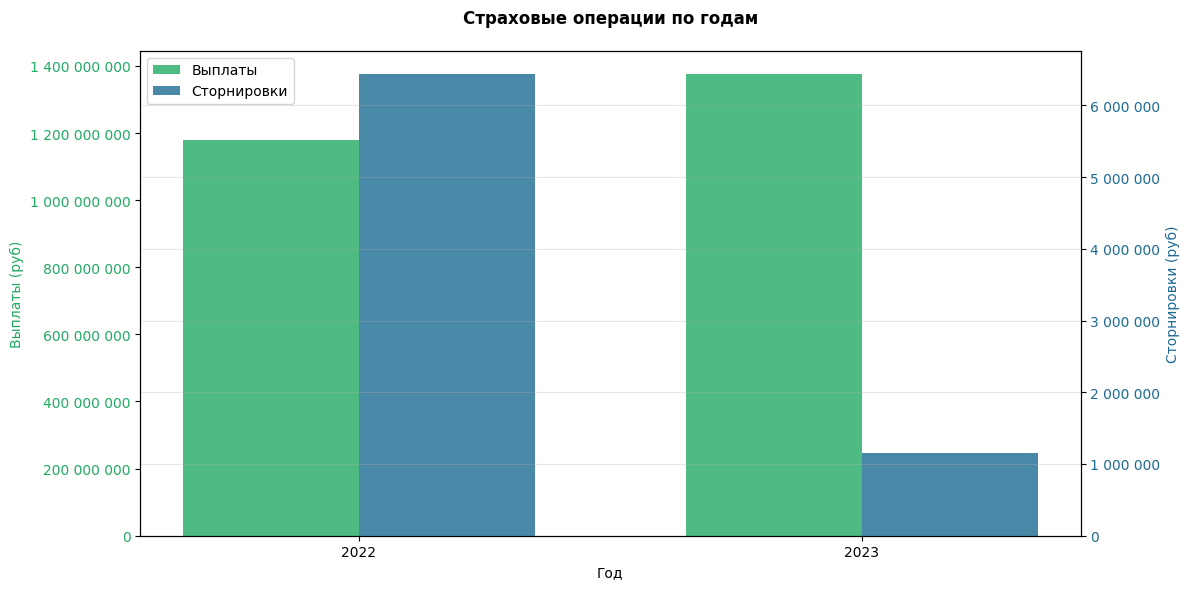

In [245]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
years = [2022, 2023]
colors = {'Выплаты': '#21AA63', 'Сторнировки': '#1D6B93'}
bar_width = 0.35

# Основная ось для выплат
ax1 = plt.gca()
ax1.set_ylabel('Выплаты (руб)', color=colors['Выплаты'])
ax1.tick_params(axis='y', labelcolor=colors['Выплаты'])

# Вторая ось для сторнировок
ax2 = ax1.twinx()
ax2.set_ylabel('Сторнировки (руб)', color=colors['Сторнировки'])
ax2.tick_params(axis='y', labelcolor=colors['Сторнировки'])

for i, year in enumerate(years):
    year_data = raw_data[raw_data['service_date'].dt.year == year]
    
    # Вычисление сумм
    pay = year_data.loc[year_data['service_amount_net'] > 0, 'service_amount_net'].sum()
    refund = abs(year_data.loc[year_data['service_amount_net'] < 0, 'service_amount_net'].sum())
    
    # Столбцы выплат на основной оси
    ax1.bar(i - bar_width/2, pay, width=bar_width, 
            color=colors['Выплаты'], alpha=0.8, 
            label='Выплаты' if i==0 else "")
    
    # Столбцы сторнировок на дополнительной оси
    ax2.bar(i + bar_width/2, refund, width=bar_width, 
            color=colors['Сторнировки'], alpha=0.8,
            label='Сторнировки' if i==0 else "")

# Настройки общей части
plt.title('Страховые операции по годам', fontweight='bold', pad=20)
plt.xticks(range(len(years)), [str(y) for y in years])
ax1.set_xlabel('Год')

# Форматирование числовых подписей
ax1.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))
ax2.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

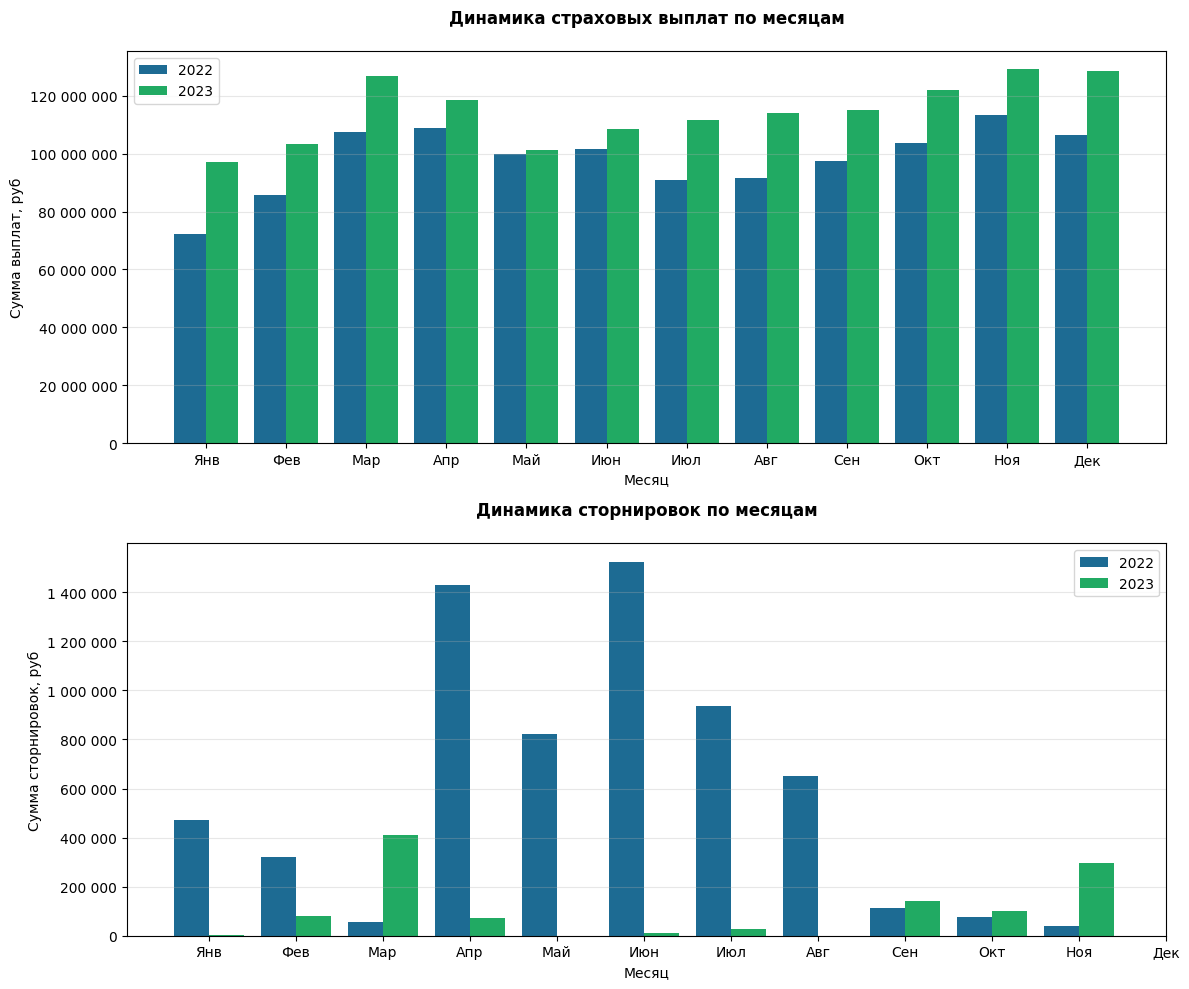

In [377]:
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Цветовая схема
colors = {'2022': '#1D6B93', '2023': '#21AA63'}  # Синий и зеленый Сбера

# 1. График страховых выплат (положительные значения)
for year in [2022, 2023]:
    # Фильтруем данные по году и положительным выплатам
    mask = (raw_data['service_date'].dt.year == year) & (raw_data['service_amount_net'] > 0)
    year_data = raw_data.loc[mask]
    
    # Группируем по месяцам и суммируем
    monthly = year_data.groupby(year_data['service_date'].dt.month)['service_amount_net'].sum()
    
    # Строим график
    ax1.bar(monthly.index + (0.2 if year == 2023 else -0.2), 
            monthly, 
            width=0.4, 
            color=colors[str(year)],
            label=str(year))

# Настройки первого графика
ax1.set_title('Динамика страховых выплат по месяцам', fontweight='bold', pad=20)
ax1.set_ylabel('Сумма выплат, руб')
ax1.set_xlabel('Месяц')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                    'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))

# 2. График сторнировок (отрицательные значения)
for year in [2022, 2023]:
    # Фильтруем данные по году и отрицательным выплатам
    mask = (raw_data['service_date'].dt.year == year) & (raw_data['service_amount_net'] < 0)
    year_data = raw_data.loc[mask]
    
    # Группируем по месяцам и суммируем абсолютные значения
    monthly = year_data.groupby(year_data['service_date'].dt.month)['service_amount_net'].sum().abs()
    
    # Строим график
    ax2.bar(monthly.index + (0.2 if year == 2023 else -0.2), 
            monthly, 
            width=0.4, 
            color=colors[str(year)],
            label=str(year))

# Настройки второго графика
ax2.set_title('Динамика сторнировок по месяцам', fontweight='bold', pad=20)
ax2.set_ylabel('Сумма сторнировок, руб')
ax2.set_xlabel('Месяц')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                     'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))

plt.tight_layout()
plt.show()

На первом графике видно, что мы имеем тренд на растующие выплаты по страховым услугам, также визуально заметна некоторая сезонность. С операцией сторнировкой все необднозначно, по сравнению с 2022 годом, сторнировки существенно уменьшились. Визуально явного тренда, а также сезонности не наблюдается.

In [547]:
unique_sdi_years = raw_data.sort_values('service_date').drop_duplicates('service_document_id')
print(f"Уникальных оказанных услуг за 2022 год: {unique_sdi_years['service_document_id'].loc[unique_sdi_years['service_date'].dt.year == 2022].nunique()}\n"
      f"Уникальных оказанных услуг за 2023 год: {unique_sdi_years['service_document_id'].loc[unique_sdi_years['service_date'].dt.year == 2023].nunique()}")

Уникальных оказанных услуг за 2022 год: 523351
Уникальных оказанных услуг за 2023 год: 560682


In [549]:
print(f"Прирост в количестве оказанных услуг г/г: {round((560682/523351)*100 - 100, 2)}%")

Прирост в количестве оказанных услуг г/г: 7.13%


In [ ]:
# Создаем фигуру с двумя подграфиками
plt.figure(figsize=(8, 6))

# Цветовая схема
colors = {'2022': '#1D6B93', '2023': '#21AA63'}  # Синий и зеленый Сбера

# # 1. График страховых выплат (положительные значения)
# for year in [2022, 2023]:
#     # Фильтруем данные по году и положительным выплатам
#     mask = raw_data.sort_values(by='service_date').drop_duplicates(subset='service_document_id', keep='first').index
#     year_data = raw_data.iloc[mask,:]
#     year_data = year_data.loc[year_data['service_date'].dt.year == year]
    
#     # Группируем по месяцам и суммируем
#     monthly = year_data.groupby(year_data['service_date'].dt.month)['service_document_id'].count()
    
#     # Строим график
#     plt.bar(monthly.index + (0.2 if year == 2023 else -0.2), 
#             monthly, 
#             width=0.4, 
#             color=colors[str(year)],
#             label=str(year))

# # Настройки первого графика
# plt.title('Динамика количества услуг по месяцам', fontweight='bold', pad=20)
# plt.ylabel('Количество страховых случаев')
# plt.xlabel('Месяц')
# plt.xticks(range(1, 13), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
#                     'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
# plt.legend()
# plt.grid(axis='y', alpha=0.3)
# plt.gca().get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))

Посмотрим на ящик с усами по полю service_amount_net, сгруппировав данные по дням

Text(0.5, 1.0, 'Ящик с усами для поля service_amount_net')

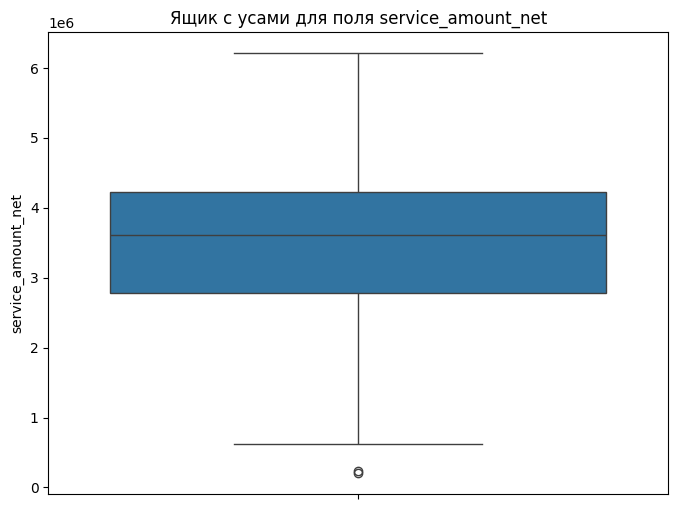

In [543]:
plt.figure(figsize=(8,6))
sns.boxplot(raw_data.groupby(raw_data['service_date'].dt.date).sum(['service_amount_net'])['service_amount_net'])
plt.title('Ящик с усами для поля service_amount_net')

Видно, что присутствуют "выбросы" ниже 25 перцентиля, в остальном выбросов по дням нет.

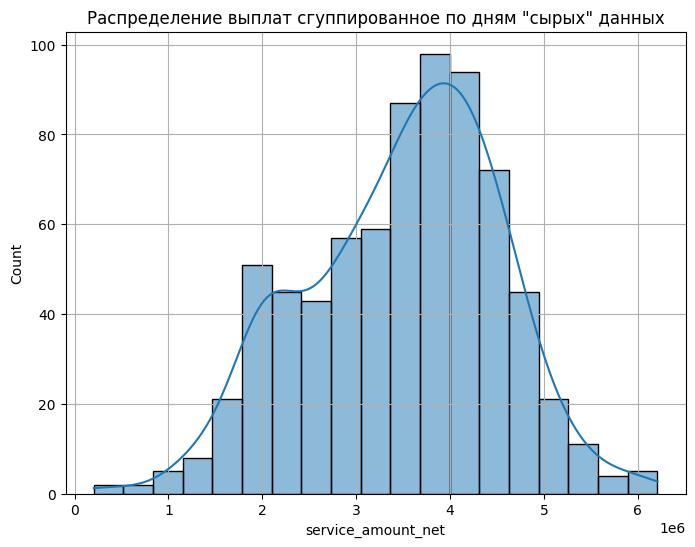

In [546]:
plt.figure(figsize=(8,6))
sns.histplot(raw_data.groupby(raw_data['service_date'].dt.date).sum(['service_amount_net'])['service_amount_net'], kde=True)
plt.title('Распределение выплат сгуппированное по дням "сырых" данных')
plt.grid()

Взглянем на 10 самых больших страховых выплат

In [208]:
raw_data.nlargest(10, 'service_amount_net') 

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
713713,0x8F559E09E5CCC0CEC413BA6997DC6C1B,0xD29BBF5ED91E9ABCAAD5E9693AC48408,2023-04-26 14:17:00,1328586.0,0xE910797DD9C83E4C9319BF69D42F3BC3,0x0B78620B11337EE1E36F66809D467E6B,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
923646,0x48C009646CF40A4BA8008FB9FA534EDB,0x53B1055BA7D74EC4B2C47CEDE32D2054,2023-09-20 08:19:00,1328586.0,0xE910797DD9C83E4C9319BF69D42F3BC3,0x0B78620B11337EE1E36F66809D467E6B,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
1085012,0xFB751FCE721F27AECD79EBCC91FFC8A6,0x5937457BE9F1170E1AB7206124F3C064,2023-12-26 19:01:00,1328586.0,0xE910797DD9C83E4C9319BF69D42F3BC3,0x0B78620B11337EE1E36F66809D467E6B,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
452678,0xAEB2693B60E0AFE7333494F91EA3D1F5,0x219B116BCB73AE16779FC1C936009B9D,2022-11-12 19:31:00,1065240.0,0x899A3B3D0D1BFC8890B23F7017CDD7FF,0x30864507D11F3E50007A25161BEB3EFF,0xA904263742B97AA3207937AF8EF39EDA,0
452671,0x08870E30BD9E34A01003A6DAB2F52BF3,0x207D5B13F7D18260D72DAA4A33EBAB5E,2022-11-12 19:31:00,712800.0,0x899A3B3D0D1BFC8890B23F7017CDD7FF,0x55AD1975DF3DB8730DB8C4AEC7354514,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
67618,0x826D1BD347DBEC3EBF0DDCE8C7C32A73,0x8C4420892C13572A78C16AE66D0EA162,2022-02-25 13:47:00,665280.0,0x3F534530EE2303C650F3EE9C2B639BC0,0x15C1F1686E2E21BD5828E212F085D1B2,0xF34E0037095421B4A492C000E42C9FCB,0
67624,0xC5AA8EC6F8394DE579AABA43FA234C48,0x5DB176A5BF1B4A94F8A46F1CAA551B56,2022-02-25 12:09:00,554256.0,0x3F534530EE2303C650F3EE9C2B639BC0,0x7766445091C3F190489FD16357A8996E,0xF60C731EF7556EE2063AB4C22FAAF311,0
311650,0x880FB0D7C65F6E02CE013E559AB82FAD,0x4CAFB1CDEDAD82145158FA2DC4714D2D,2022-08-10 15:39:00,519750.0,0xE5013371C11522C5409B813A2C436DF2,0x8AB0375E3ACD4516B54FF89B236CE336,0x45DD40279D5973542F6EDC81CCA0359A,1
255654,0x26CF725326BA780FD6EBF50D2A63D7D6,0x6405DE885695A0D88B530E26AA288809,2022-06-29 16:27:00,515000.0,0x91AACF1357EF55C8FAC529E06A19220A,0x21DB79E018B9DC084B84853674A5CECF,0x0B0C37312C24D84A168F2EE1AF6D4C1C,1
67612,0xB53E08C86AC28351C7D051812E2182B2,0x578C99ACBF4AAB786BF9775D4FDF8453,2022-02-25 12:09:00,461880.0,0x3F534530EE2303C650F3EE9C2B639BC0,0x7766445091C3F190489FD16357A8996E,0xF60C731EF7556EE2063AB4C22FAAF311,0


In [ ]:
def detect_clean_outliers_iqr(data, column, threshold=1.5, clean = False):
    """
    Возвращает DataFrame с выбросами по правилу IQR.
    
    Parameters:
        data (pd.DataFrame): Исходные данные
        column (str): Название столбца для анализа
        threshold (float): Множитель IQR (стандартно 1.5, можно 3 для более строгого отбора)
    
    Returns:
        pd.DataFrame: Строки, содержащие выбросы
    """
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    if clean == True:
        return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return outliers

# Пример использования
outliers = detect_clean_outliers_iqr(raw_data, 'service_amount_net', threshold=1.5)
print(f"Найдено выбросов: {len(outliers)}")

Найдено выбросов: 0


Создадим копию исходных данных, на которых будем далее проводить манипуляции и эксперименты.
Для анализа переодичности проведем feature engineering и создадим новые атрибуты: месяц, квартал, день, день недели. Также добавим переодичность по месяцам, а оригинальный формат даты service_date с часами, минутами и секундами заменим на простой день (yyyy-mm-dd)

Уберем из датасета записи, соотвествующие услугам чекап (service_amount_net = 0) и одну запись, где service_amount_net = 1.

## Preprocessing

In [474]:
preprocessed_data = raw_data.copy()

preprocessed_data['quarter'] = preprocessed_data['service_date'].dt.quarter
preprocessed_data['month'] = preprocessed_data['service_date'].dt.month
preprocessed_data['day'] = preprocessed_data['service_date'].dt.day
preprocessed_data['day_of_week'] = preprocessed_data['service_date'].dt.day_of_week
preprocessed_data['year_months'] = preprocessed_data['service_date'].dt.to_period('M')
preprocessed_data['service_date'] = preprocessed_data['service_date'].dt.date


preprocessed_data = preprocessed_data.loc[
    (preprocessed_data['service_amount_net'] != 0)
      & (preprocessed_data['service_amount_net'] != 1)]
preprocessed_data.shape

(1086550, 13)

In [499]:
# дельта по сторнировке 
preprocessed_data_sdi_delta = preprocessed_data.copy()
sum_sdi = preprocessed_data_sdi_delta[['service_document_id', 'service_amount_net']].groupby('service_document_id').sum('service_amount_net').sort_values('service_document_id')

preprocessed_data_sdi_delta = preprocessed_data_sdi_delta.sort_values('service_date').drop_duplicates('service_document_id', keep='first').sort_values('service_document_id')
# preprocessed_data_sdi_delta = pd.merge(preprocessed_data_sdi_delta, sum_sdi, 'inner', on='service_document_id').drop(columns=['service_amount_net_x'])
# preprocessed_data_sdi_delta.rename(columns={'service_amount_net_y': 'service_amount_net'}, inplace=True)
preprocessed_data_sdi_delta['service_amount_net'] = sum_sdi['service_amount_net'].to_list()
preprocessed_data_sdi_delta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1079611 entries, 20326 to 233088
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype    
---  ------               --------------    -----    
 0   service_document_id  1079611 non-null  object   
 1   account_document_id  1079611 non-null  object   
 2   service_date         1079611 non-null  object   
 3   service_amount_net   1079611 non-null  float64  
 4   patient_id           1079611 non-null  object   
 5   service_code         1079611 non-null  object   
 6   service_name         1079611 non-null  object   
 7   is_hospital          1079611 non-null  int64    
 8   quarter              1079611 non-null  int32    
 9   month                1079611 non-null  int32    
 10  day                  1079611 non-null  int32    
 11  day_of_week          1079611 non-null  int32    
 12  year_months          1079611 non-null  period[M]
dtypes: float64(1), int32(4), int64(1), object(6), period[M](1)
memory usage: 9

In [500]:
# избавимся от нулевых сумм
preprocessed_data_sdi_delta = preprocessed_data_sdi_delta.loc[preprocessed_data_sdi_delta['service_amount_net'] != 0]
preprocessed_data_sdi_delta.shape

(1078777, 13)

In [561]:
preprocessed_data_sdi_delta.loc[pd.to_datetime(preprocessed_data_sdi_delta['service_date']).dt.year == 2023].groupby('is_hospital')['service_amount_net'].mean()

is_hospital
0    2333.722739
1    3746.089007
Name: service_amount_net, dtype: float64

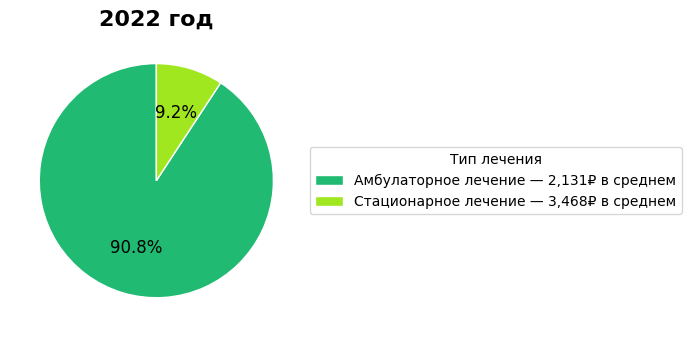

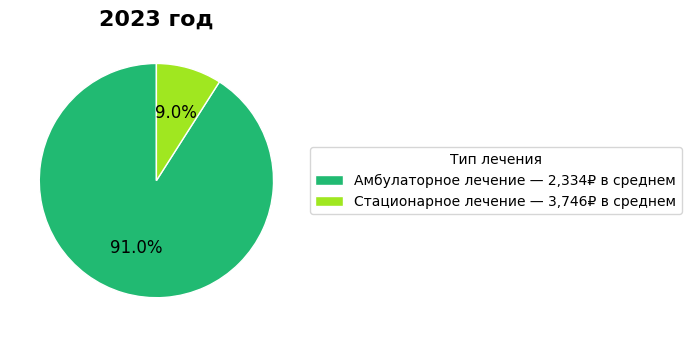

In [568]:
#график пирог по типу is_hospital

colors = ['#21BA72', '#A0E720']
labels_map = {0: 'Амбулаторное лечение', 1: 'Стационарное лечение'}

def plot_pie_for_year(data, year):
    data_year = data[pd.to_datetime(data['service_date']).dt.year == year]
    
    counts = data_year.groupby('is_hospital')['is_hospital'].count()
    means = data_year.groupby('is_hospital')['service_amount_net'].mean()

    # Сортируем по [0, 1] чтобы цвета всегда совпадали
    values = [counts.get(k, 0) for k in [0, 1]]
    mean_values = [means.get(k, 0) for k in [0, 1]]
    labels = [labels_map[k] for k in [0, 1]]
    
    # Текст для легенды
    legend_labels = [f"{label} — {mean:,.0f}₽ в среднем" for label, mean in zip(labels, mean_values)]

    # Рисуем
    fig, ax = plt.subplots(figsize=(7, 7))
    wedges, texts, autotexts = ax.pie(
        values,
        labels=None,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops=dict(edgecolor='white'),
        textprops={'fontsize': 12}
    )

    # Название
    ax.set_title(f"{year} год", fontsize=16, fontweight='bold')

    # Легенда сбоку
    ax.legend(wedges, legend_labels, title="Тип лечения", loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

# Построим по очереди
plot_pie_for_year(preprocessed_data_sdi_delta, 2022)
plot_pie_for_year(preprocessed_data_sdi_delta, 2023)


In [ ]:
# Группировка по месяцам дням, месяцам
preprocessed_data_grouped_month = preprocessed_data.copy()


После предобработки данных взлягнем на распределение по выплатам

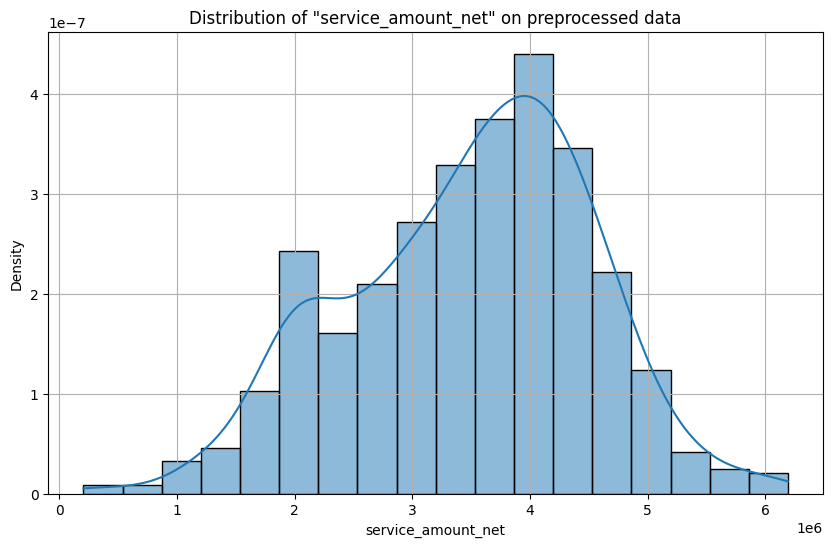

In [501]:
ts_delta = preprocessed_data_sdi_delta.groupby('service_date').sum('service_amount_net')['service_amount_net']
plt.figure(figsize=(10,6))
sns.histplot(ts_delta, bins=int(2*(len(ts_delta)**(1/3))), kde=True, stat='density') # для опр-ия количества bins воспользуемся правилом Rice (2 * pow(N, 1/3))
plt.title('Distribution of "service_amount_net" on preprocessed data')
plt.grid()

Text(0.5, 1.0, 'Ящик с усами для поля service_amount_net')

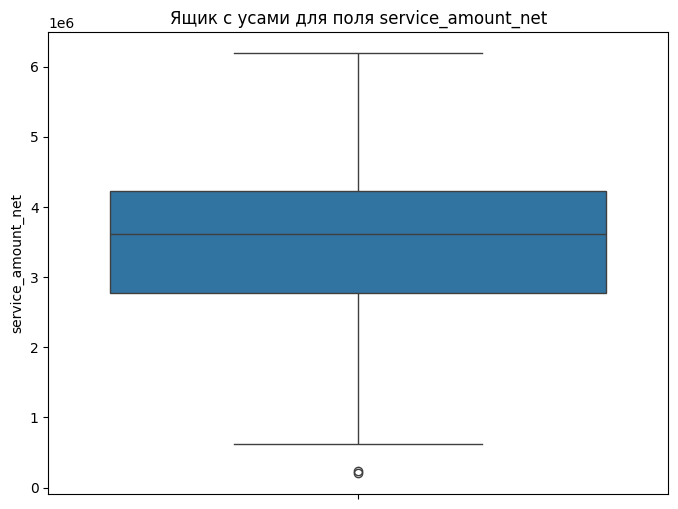

In [502]:
plt.figure(figsize=(8,6))
sns.boxplot(ts_delta)
plt.title('Ящик с усами для поля service_amount_net')

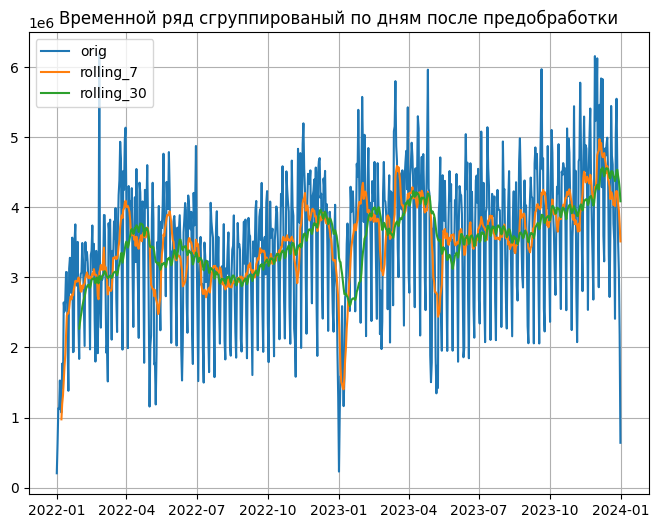

In [545]:
plt.figure(figsize=(8,6))
plt.plot(ts_delta, label='orig')
plt.plot(ts_delta.rolling(7).mean(), label='rolling_7')
plt.plot(ts_delta.rolling(30).mean(), label='rolling_30')

# plt.plot(np.log(ts_delta.rolling(7).mean()).diff(), label='rolling_7')
# plt.plot(np.log(ts_delta.rolling(30).mean()).diff(), label='rolling_30')
plt.title('Временной ряд сгруппированый по дням после предобработки')
plt.legend()
plt.grid()

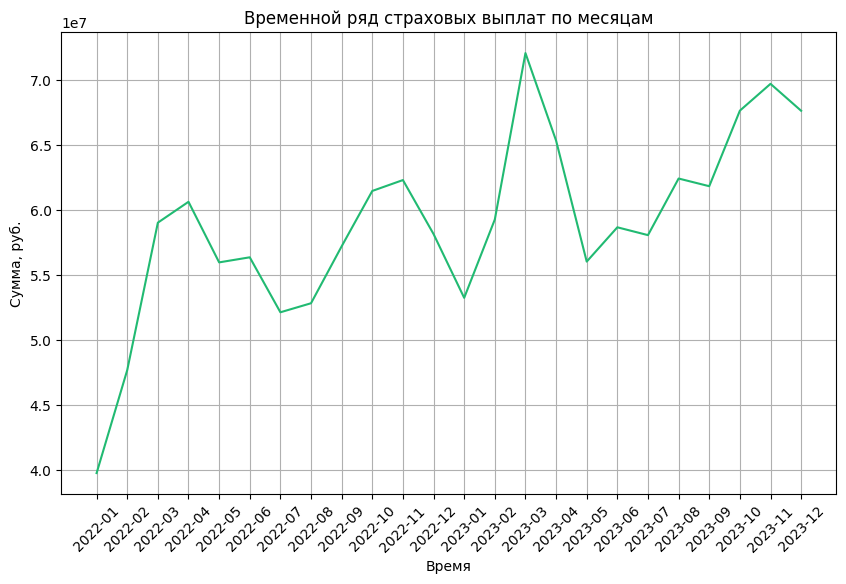

In [353]:
ts = preprocessed_data[['year_months', 'service_amount_net']].groupby(by=['year_months']).sum().reset_index()
plt.figure(figsize=(10,6))
plt.plot(ts['year_months'].apply(lambda x: str(x)), ts['service_amount_net'], color = '#21BA72')
plt.title('Временной ряд страховых выплат по месяцам')
plt.xticks(rotation=45)
plt.xlabel('Время')
plt.ylabel('Сумма, руб.')
plt.grid()

# Определение сезонности, автокорреляции и прочее

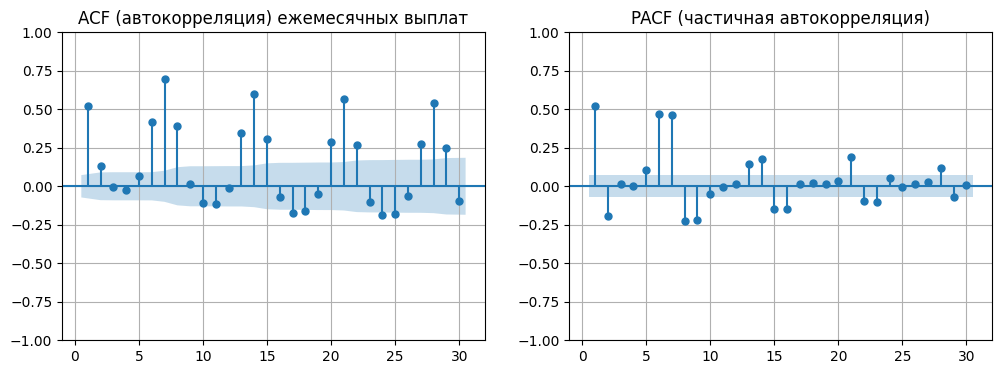

In [523]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(ts_delta, lags=30, ax=plt.gca(), zero=False)
plt.title("ACF (автокорреляция) ежемесячных выплат")
plt.grid()

plt.subplot(1,2,2)
plot_pacf(ts_delta, lags=30, ax=plt.gca(), zero=False)
plt.title("PACF (частичная автокорреляция)")
plt.grid()

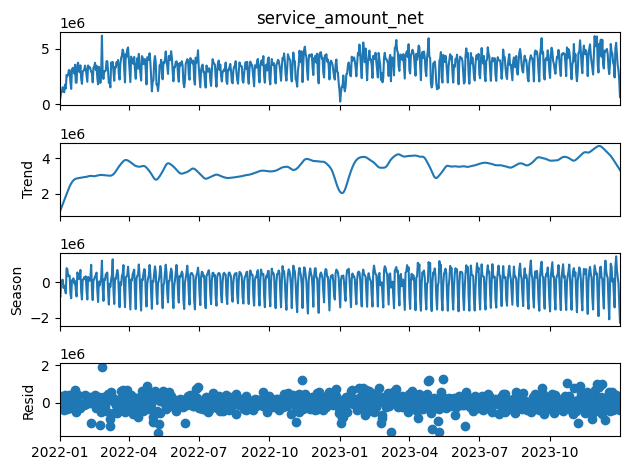

In [531]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts_delta, period=14)  # если, например, сезонность недельная
result = stl.fit()
result.plot()

# Получим очищенный ряд (без тренда и сезонности)
cleaned = result.resid

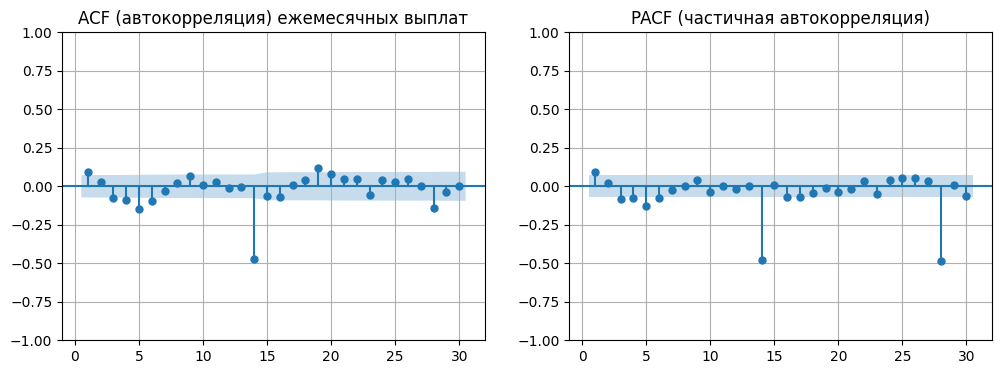

In [532]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(cleaned, lags=30, ax=plt.gca(), zero=False)
plt.title("ACF (автокорреляция) ежемесячных выплат")
plt.grid()

plt.subplot(1,2,2)
plot_pacf(cleaned, lags=30, ax=plt.gca(), zero=False)
plt.title("PACF (частичная автокорреляция)")
plt.grid()

# Feature engineering

In [ ]:
data_4model = preprocessed_data.copy()

# Baseline

Для обучения воспользуем несколькими вариантами ML моделями, а именно Prophet, CatBoost и LightGBM. Данный выбор пал из-за их возможности работы с категориальынм типом данных, и широкой настройкой параметров.

Также в рамках попытки применения SOTA модели будет рассмотрены резервуарные вычисления, в частности классическая модель ESN.

## Prophet

In [ ]:
def cross_validation_prop(time_series, model, forecast, schema='schema_1', train_size):
    

# Predictions